## Modeling electron spins (1D Ising model)

In [7]:
import numpy as np
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn')

In [22]:
def init_grid(size = (10,)):
    grid = torch.randn(*size)
    grid[grid > 0] = 1
    grid[grid <= 0] = 0
    grid = grid.byte()
    return grid

def get_reward(neighbours, agent):
    reward = -1
    for n in neighbours:
        if n == agent:
            reward += 0.9
    reward *= 2.
    return reward

def gen_params(num, size):
    ret = []
    for i in range(num):
        vec = torch.randn(size) / 10.0
        vec.requires_grad = True
        ret.append(vec)
    return ret

def q_func(state, theta, layers = [(4, 20), (20, 2)], activation = torch.tanh):
    l1n = layers[0]
    l1s = np.prod(l1n)
    theta_1 = theta[0:l1s].reshape(l1n)
    l2n = layers[1]
    l2s = np.prod(l2n)
    theta_2 = theta[l1s:(l2s+l1s)].reshape(l2n)
    bias = torch.ones((1, theta_1.shape[1]))
    l1 = state @ theta_1 + bias
    l1 = torch.nn.functional.elu(l1)
    l2 = activation(l1 @ theta_2)
    l2 = l2.flatten()
    return l2

def get_substate(b):
    s = torch.zeros(2)
    if b > 0:
        s[1] = 1
    else:
        s[0] = 1
    return s

def joint_state(s):
    s1_ = get_substate(s[0])
    s2_ = get_substate(s[1])
    ret = (s1_.reshape(2, 1) @ s2_.reshape(1, 2)).flatten()
    return ret

tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1],
       dtype=torch.uint8)


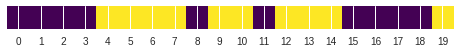

In [44]:
plt.figure(figsize = (8, 5))
size = (20,)
hid_layer = 20
params = gen_params(size[0], 4*hid_layer+hid_layer*2)
grid = init_grid(size = size)
grid_ = grid.clone()
print(grid)

plt.imshow(np.expand_dims(grid, 0), cmap = 'viridis')
plt.xticks(list(range(20)))
plt.yticks([]);

In [46]:
num_epochs = 200
lr = 1e-3
losses = [[] for i in range(size[0])]

for i in range(num_epochs):
    for j in range(size[0]):
        l = j-1 if j-1 >= 0 else size[0]-1
        r = j+1 if j+1 < size[0] else 0
        state_ = grid[[l, r]]
        state = joint_state(state_)
        q_vals = q_func(state.float().detach(), params[j], layers = [(4, hid_layer), (hid_layer, 2)])
        q_max = torch.argmax(q_vals, dim = 0).detach().item()
        action = int(q_max)
        grid_[j] = action
        reward = get_reward(state_.detach(), action)
        with torch.no_grad():
            target = q_vals.clone()
            target[action] = reward
        loss = torch.sum(torch.pow(q_vals - target, 2))
        losses[j].append(loss.detach().numpy())
        loss.backward()
        with torch.no_grad():
            params[j] = params[j] - lr * params[j].grad
        params[j].requires_grad = True
    with torch.no_grad():
        grid.data = grid_.data

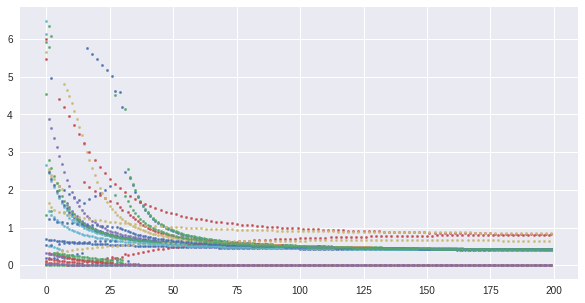

In [70]:
fig = plt.figure(figsize = (10, 5))
for i in range(size[0]):
    plt.scatter(np.arange(len(losses[i])),losses[i], s = 5.5)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       dtype=torch.uint8) tensor(13)


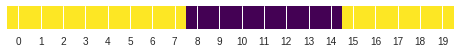

In [77]:
print(grid,grid.sum())

plt.imshow(np.expand_dims(grid,0), cmap = 'viridis')
plt.xticks(list(range(20)))
plt.yticks([]);

## Mean field Q-learning (2D Ising model)

In [78]:
from collections import deque
from random import shuffle

In [79]:
def softmax_policy(qvals, temp = 0.9):
    soft = torch.exp(qvals / temp) / torch.sum(torch.exp(qvals / temp))
    action = torch.multinomial(soft, 1)
    return action

def get_coords(grid, j):
    x = int(np.floor(j / grid.shape[0]))
    y = int(j - x * grid.shape[0])
    return x, y

def get_reward_2d(action, action_mean):
    r = (action * (action_mean - action / 2)).sum() / action.sum()
    return torch.tanh(5 * r)

def mean_action(grid, j):
    x, y = get_coords(grid, j)   
    action_mean = torch.zeros(2)
    for i in [-1, 0, 1]:
        for k in [-1, 0, 1]:
            if i == k == 0:
                continue
            x_, y_ = x + i, y + k
            x_ = x_ if x_ >= 0 else grid.shape[0] - 1
            y_ = y_ if y_ >= 0 else grid.shape[1] - 1
            x_ = x_ if x_ < grid.shape[0] else 0
            y_ = y_ if y_ < grid.shape[1] else 0
            cur_n = grid[x_, y_]
            s = get_substate(cur_n)
            action_mean += s
    action_mean /= action_mean.sum()
    return action_mean

tensor(50)


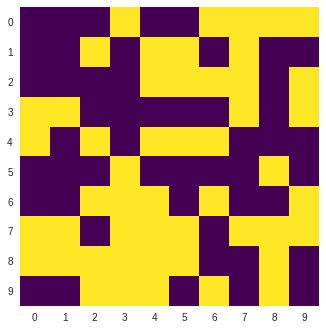

In [88]:
size = (10,10)
J = np.prod(size)
hid_layer = 10
layers = [(2, hid_layer), (hid_layer, 2)]
params = gen_params(1, 2*hid_layer+hid_layer*2)
grid = init_grid(size = size)
grid_ = grid.clone()
grid__ = grid.clone()

print(grid.sum())

plt.imshow(grid, cmap = 'viridis')
plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.grid(False)

In [90]:
epochs = 75
lr = 0.0001
num_iter = 3
losses = [[] for i in range(size[0])]
replay_size = 50
replay = deque(maxlen = replay_size)
batch_size = 10
gamma = 0.9
losses = [[] for i in range(J)]

for i in range(epochs):
    act_means = torch.zeros((J, 2))
    q_next = torch.zeros(J)
    for m in range(num_iter):
        for j in range(J):
            action_mean = mean_action(grid_, j).detach()
            act_means[j] = action_mean.clone()
            qvals = q_func(action_mean.detach(), params[0], layers = layers)
            action = softmax_policy(qvals.detach(), temp=0.5)
            grid__[get_coords(grid_, j)] = action
            q_next[j] = torch.max(qvals).detach()
        grid_.data = grid__.data
    grid.data = grid_.data
    actions = torch.stack([get_substate(a.item()) for a in grid.flatten()])
    rewards = torch.stack([get_reward_2d(actions[j], act_means[j]) for j in range(J)])
    exp = (actions, rewards, act_means, q_next)
    replay.append(exp)
    shuffle(replay)
    if len(replay) > batch_size:
        ids = np.random.randint(low=0, high = len(replay), size = batch_size)
        exps = [replay[idx] for idx in ids]
        for j in range(J):
            jacts = torch.stack([ex[0][j] for ex in exps]).detach()
            jrewards = torch.stack([ex[1][j] for ex in exps]).detach()
            jmeans = torch.stack([ex[2][j] for ex in exps]).detach()
            vs = torch.stack([ex[3][j] for ex in exps]).detach()
            qvals = torch.stack([q_func(jmeans[h].detach(), params[0], layers = layers) \
                                for h in range(batch_size)])
            target = qvals.clone().detach()
            target[:, torch.argmax(jacts, dim = 1)] = jrewards + gamma * vs
            loss = torch.sum(torch.pow(qvals - target.detach(), 2))
            losses[j].append(loss.item())
            loss.backward()
            with torch.no_grad():
                params[0] = params[0] - lr * params[0].grad
            params[0].requires_grad = True

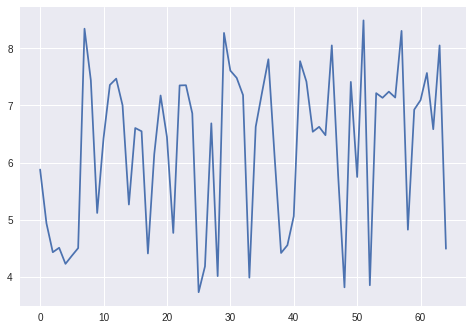

In [92]:
plt.plot(np.array(losses).mean(axis = 0));

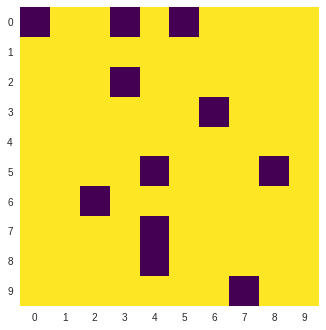

In [93]:
plt.imshow(grid, cmap = 'viridis')
plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.grid(False)